# Creating a clean boundary file for Massachusetts municipalities

## The problem

In Massachusetts, as with most of the New England states, the most important jurisdictions are **municipalities** — we sometimes call them "cities" or "towns," although these terms are not interchangable and their distinction relies on a complicated explanation of jurisdictional history and local government structure. 

There are two major providers for boundary files of Massachusetts municipalities:

* MassGIS has a **[Community Boundaries (Towns) from Survey Points](https://docs.digital.mass.gov/dataset/massgis-data-community-boundaries-towns-survey-points)** dataset that contains the most accurate geographic transcription of towns's legal borders, based on the survey points that define these borders. However, MassGIS does not properly encode the Census GEOID for each town, making this file unsuitable for joining with variables from Census products like the American Community Survey.

* The Census geography which most appropriately relates to New England municipalities is the **county subdivision** (or **COUSUB**). The Census Bureau's **Cartographic Boundary File** dataset, which is suitable for thematic mapping though has [caveats for more technical purposes](https://www.census.gov/programs-surveys/geography/technical-documentation/naming-convention/cartographic-boundary-file.html), is available [here](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html).
  * Note that sometimes the Census "Place" geography will be used, incorrectly, to refer to Massachusetts cities and towns. See pages 15–18 of [this Census presentation](https://www.census.gov/content/dam/Census/data/developers/understandingplace.pdf) for more.

## Source datasets

* The directory `data-raw/townssurvey_shp` was downloaded and unzipped from <http://download.massgis.digital.mass.gov/shapefiles/state/townssurvey_shp.zip> on 2020-10-19.
* The directory `data-raw/cb_2019_25_cousub_500k` was downloaded and unzipped from <https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_25_cousub_500k.zip> on 2020-10-19.

## Errata

* When a town changes its governmental form from a town to a city, its Census county subdivision code changes, too. This can make for errors when pulling in data keyed to the GEOID of an earlier year. (Towns that have become a city but petitioned to keep their "town" designation name receive a confusing nomenclature from the Census, e.g., Randolph Town city.) Some recent changes to be aware of are:
  * Framingham changed from `2501724925` to `2501724960` in 2018 when it became a city.
  * Randolph changed from `2502155955` to `2502156000` in 2019 when it became a city.



To run this data cleanup, we're going to use the following Python packages:

* **geopandas** for all our geoprocessing needs
* **difflib** because we're going to have to do fuzzy matching between two datasets

In [1]:
import geopandas as gpd
from difflib import get_close_matches

Let's load the MassGIS boundary file into a GeoDataFrame and plot it. We'll load the file that uses Multipolygon geometries and has a generalized coastline.

<AxesSubplot:>

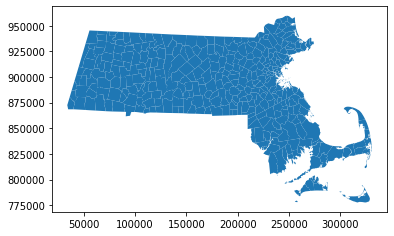

In [2]:
massgis_df = gpd.read_file('data-raw/townssurvey_shp/TOWNSSURVEY_POLYM_GENCOAST.shp')
massgis_df.plot()

Looking at the axes, we can see we're not in the WGS84 coordinate system. We can print out the CRS, which is EPSG:26986 / Massachusetts Mainland.

In [3]:
massgis_df.crs

<Projected CRS: EPSG:26986>
Name: NAD83 / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA - Massachusetts - SPCS - mainland
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

From here on out, we want to work with EPSG:4326 coordinates, so let's reproject this GeoDataFrame.

<AxesSubplot:>

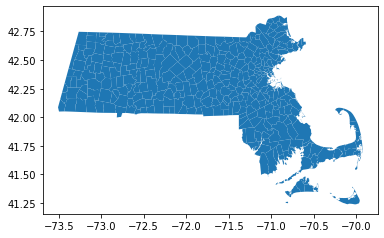

In [4]:
massgis_df = massgis_df.to_crs('EPSG:4326')
massgis_df.plot()

Now, let's bring in the Census cartographic boundary file for county subdivisions in Massachusetts.

<AxesSubplot:>

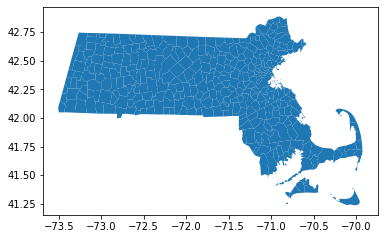

In [5]:
census_df = gpd.read_file('data-raw/cb_2019_25_cousub_500k/cb_2019_25_cousub_500k.shp')
census_df.plot()

So, how are we going to merge these two, since they don't have an identifier in common? The MassGIS dataset's `TOWN` attribute is similar, though not exactly the same as, the Census dataset's `NAME` attribute. So, we're going to create a fuzzy matching function, borrowed from [this Stack Overflow answer](https://stackoverflow.com/a/60908516).

In [6]:
def fuzzy_merge(df1, df2, left_on, right_on, how='left', cutoff=1.0):
    df_other= df2.copy()
    df_other[left_on] = [get_closest_match(x, df1[left_on], cutoff) 
                         for x in df_other[right_on]]
    return df1.merge(df_other, on=left_on, how=how)

def get_closest_match(x, other, cutoff):
    matches = get_close_matches(x, other, cutoff=cutoff)
    return matches[0] if matches else None

We're going to do two conversions to improve the fuzzy matching. First, we're going to convert both the `TOWN` attribute in the MassGIS dataset and the `NAME` attribute in the Census dataset to lowercase. Then, we're going to trim out any text from the Census dataset that reads " Town" (including that space), so that we can get rid of all the confusing census names like "Bridgewater Town." Finally, we'll drop the `geometry` from the Census dataset, since we're only going to use the MassGIS geometry later.

In [7]:
massgis_df['town_lc']=massgis_df['TOWN'].apply(lambda x: x.lower())
census_df['town_lc']=census_df['NAME'].apply(lambda x: x.split(" Town")[0].lower())
census_df.drop(columns=['geometry'], inplace=True)

Now let's try running it with the MassGIS dataset as the left table of the fuzzy join, since we want to use its geometries eventually.

In [8]:
merged_df = fuzzy_merge(massgis_df, census_df, left_on="town_lc", right_on="town_lc")

OK, in order to check our merge, let's look at all the records where the `GEOID` is null, meaning that a MassGIS record didn't match to any Census record.

In [9]:
merged_df[merged_df['GEOID'].isnull()]

,TOWN,TOWN_ID,POP1980,POP1990,POP2000,POPCH80_90,POPCH90_00,TYPE,FOURCOLOR,FIPS_STCO,...,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER
275,MANCHESTER,166,5354,5286,5228,-68,-58,T,2,25009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Did you know there's an entire feature film about this data error?

![film poster](https://www.uncut.co.uk/wp-content/uploads/2017/01/manchester-by-the-sea-quad.jpg)

Let's just coerce the MassGIS dataset to use the full name of that town, then rerun.

In [10]:
massgis_df.replace({'town_lc': {'manchester': 'manchester-by-the-sea'}}, inplace=True)
merged_df = fuzzy_merge(massgis_df, census_df, left_on="town_lc", right_on="town_lc")
merged_df[merged_df['GEOID'].isnull()]

,TOWN,TOWN_ID,POP1980,POP1990,POP2000,POPCH80_90,POPCH90_00,TYPE,FOURCOLOR,FIPS_STCO,...,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER


Awesome! Now, let's filter down to only the columns we want.

In [11]:
merged_df = merged_df[['TOWN','TOWN_ID','NAME','GEOID','geometry']]
merged_df.head()

,TOWN,TOWN_ID,NAME,GEOID,geometry
0,AQUINNAH,104,Aquinnah,2500701585,"POLYGON ((-70.80537 41.35563, -70.80525 41.355..."
1,NANTUCKET,197,Nantucket,2501943790,"MULTIPOLYGON (((-70.27008 41.31044, -70.27012 ..."
2,CHILMARK,62,Chilmark,2500713800,"MULTIPOLYGON (((-70.81018 41.26112, -70.81009 ..."
3,EDGARTOWN,89,Edgartown,2500721150,"POLYGON ((-70.55981 41.42236, -70.55978 41.422..."
4,WEST TISBURY,327,West Tisbury,2500778235,"POLYGON ((-70.65566 41.46037, -70.61510 41.413..."


And do a bit of column renaming.

In [12]:
merged_df.rename(columns={'TOWN': "massgis_name", "TOWN_ID": "massgis_town_id", "NAME": "census_name"}, inplace=True)
merged_df.head()

,massgis_name,massgis_town_id,census_name,GEOID,geometry
0,AQUINNAH,104,Aquinnah,2500701585,"POLYGON ((-70.80537 41.35563, -70.80525 41.355..."
1,NANTUCKET,197,Nantucket,2501943790,"MULTIPOLYGON (((-70.27008 41.31044, -70.27012 ..."
2,CHILMARK,62,Chilmark,2500713800,"MULTIPOLYGON (((-70.81018 41.26112, -70.81009 ..."
3,EDGARTOWN,89,Edgartown,2500721150,"POLYGON ((-70.55981 41.42236, -70.55978 41.422..."
4,WEST TISBURY,327,West Tisbury,2500778235,"POLYGON ((-70.65566 41.46037, -70.61510 41.413..."


OK, pretty much done. Now let's export the merged file to a GeoJSON.

In [13]:
merged_df.to_file("data-cooked/mass-municipalities.geojson", driver="GeoJSON")

Now you have a nice boundary file for Massachusetts, using MassGIS data but with normalized names and accurate GEOIDs suitable for joining with Census data!

From here, you may want to take the output GeoJSON and run it through [MapShaper](https://github.com/mbloch/mapshaper) to simplify the geometries or convert to TopoJSON for web projects.